Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# **Importing Skin Cancer Data**

Downloaded data from the link provided and uploaded it to google drive. After importing the required libraries, data will be imported by mounting the google drive.

# **Importing all the important libraries**

In [27]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D

In [1]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [28]:
# defining the path for train and test images
data_dir_train = pathlib.Path('gdrive/MyDrive/CNN_assignment/Train')
data_dir_test = pathlib.Path('gdrive/MyDrive/CNN_assignment/Test')

In [29]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
128


# **Load using keras.preprocessing**
Let's load these images off disk using the helpful image_dataset_from_directory utility.

# **Creating a dataset**
Define some parameters for the loader:

In [30]:
batch_size = 32
img_height = 180
img_width = 180


Use 80% of the images for training, and 20% for validation.

In [31]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [32]:
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [33]:
# listing out all the classes of skin cancer and store them in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# **Visualizing the data**

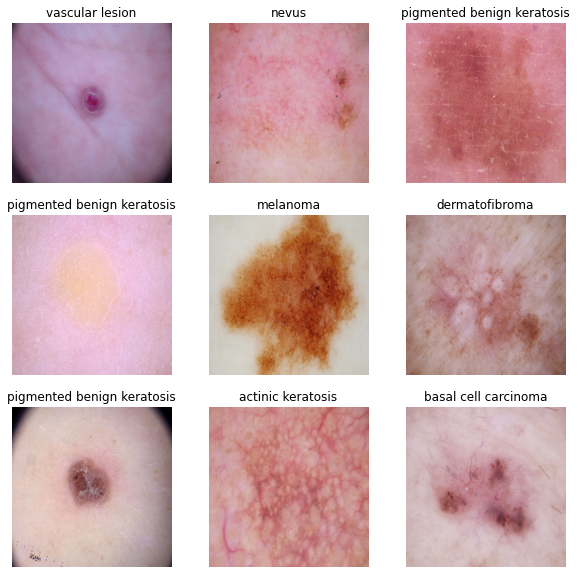

In [10]:
# first nine images from train dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Model 1 - Without doing Data Augmentation and correcting Class Imbalance**
Detecting 9 classes present in the dataset using layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1)

In [12]:
input_shape = (img_height, img_width, 3)

model = Sequential()

model.add(tf.keras.layers.Rescaling(1./255, input_shape = input_shape))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = input_shape, padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(9, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0

# **Compiling the model**
Choose an appropirate optimiser and loss function for model training

In [13]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [14]:
# view the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0

# **Training the model**

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 630s 5s/step - loss: 18.0286 - accuracy: 0.2896 - val_loss: 13.2078 - val_accuracy: 0.0403
Epoch 2/20
56/56 [==============================] - 155s 3s/step - loss: 2.1967 - accuracy: 0.2623 - val_loss: 13.3689 - val_accuracy: 0.0492
Epoch 3/20
56/56 [==============================] - 158s 3s/step - loss: 1.9934 - accuracy: 0.2863 - val_loss: 11.4481 - val_accuracy: 0.0492
Epoch 4/20
56/56 [==============================] - 154s 3s/step - loss: 1.9177 - accuracy: 0.3181 - val_loss: 4.9305 - val_accuracy: 0.1700
Epoch 5/20
56/56 [==============================] - 154s 3s/step - loss: 1.8912 - accuracy: 0.3265 - val_loss: 5.4948 - val_accuracy: 0.1566
Epoch 6/20
56/56 [==============================] - 154s 3s/step - loss: 1.8822 - accuracy: 0.3410 - val_loss: 2.7227 - val_accuracy: 0.2707
Epoch 7/20
56/56 [==============================] - 153s 3s/step - loss: 1.7937 - accuracy: 0.3655 - val_loss: 1.9811 - val_accuracy: 0.3378
Epoch 8/20
56/56 [==

# **Visualizing training results**

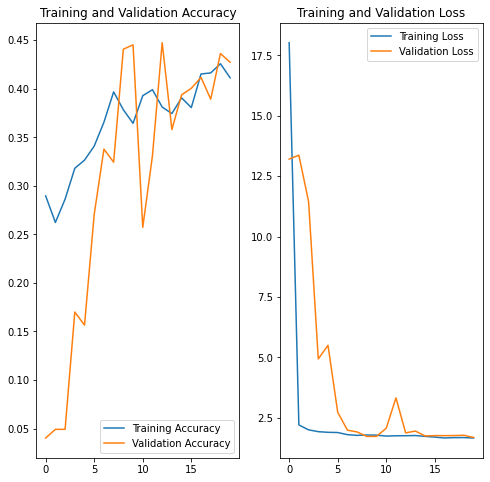

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Observations:**
1. Training and Validation accuracies are ~41% and ~43% respectively which indicates underfitting because they are low but not overfitting because they are inline with each other. 
2. I will use Data Augmentation, Dropout layers, and more conv layers to improve the accuracy.    

# **Model 2 - Adding Data Augmentation, Dropout layers and Conv layers**

# **Data Augmentation**

In [15]:
data_augmentation = tf.keras.Sequential()
data_augmentation.add(tf.keras.layers.RandomFlip("horizontal_and_vertical"))
data_augmentation.add(tf.keras.layers.RandomRotation(0.2))

# **Visualizing training image**

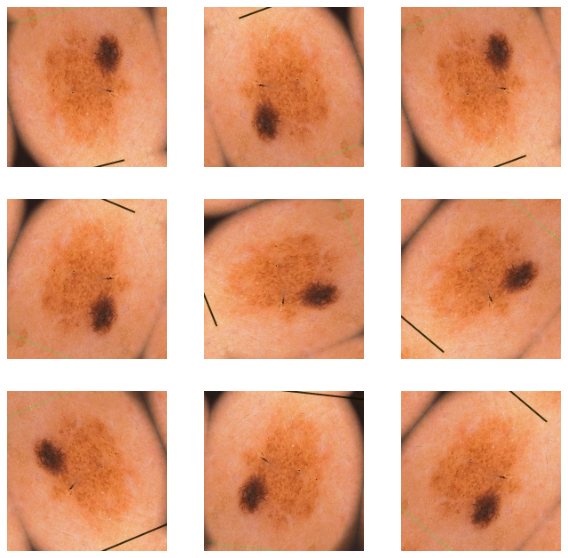

In [16]:
plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(image, training = True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

# **Creating the model**

In [17]:
model_augmented = Sequential()

model_augmented.add(tf.keras.layers.Rescaling(1./255, input_shape = input_shape))

model_augmented.add(data_augmentation)

model_augmented.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = input_shape, padding = 'same'))
model_augmented.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same'))
model_augmented.add(MaxPool2D(pool_size = (2, 2)))
model_augmented.add(Dropout(0.2))

model_augmented.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model_augmented.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model_augmented.add(MaxPool2D(pool_size = (2, 2)))
model_augmented.add(Dropout(0.2))

model_augmented.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model_augmented.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model_augmented.add(MaxPool2D(pool_size = (2, 2)))
model_augmented.add(Dropout(0.2))

model_augmented.add(Flatten())

model_augmented.add(Dense(512, activation = 'relu'))
model_augmented.add(Dropout(0.5))

model_augmented.add(Dense(9, activation = 'softmax'))

model_augmented.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 32)        0         
                                                      

# **Compiling the model**

In [18]:
model_augmented.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

# **Training the model**

In [19]:
epochs = 20
history = model_augmented.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 71s 1s/step - loss: 2.1262 - accuracy: 0.1942 - val_loss: 2.0625 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 6s 106ms/step - loss: 2.0056 - accuracy: 0.2288 - val_loss: 1.8969 - val_accuracy: 0.3289
Epoch 3/20
56/56 [==============================] - 6s 106ms/step - loss: 1.8591 - accuracy: 0.3170 - val_loss: 1.7493 - val_accuracy: 0.3356
Epoch 4/20
56/56 [==============================] - 6s 107ms/step - loss: 1.7098 - accuracy: 0.3778 - val_loss: 1.5986 - val_accuracy: 0.4027
Epoch 5/20
56/56 [==============================] - 6s 107ms/step - loss: 1.6268 - accuracy: 0.3884 - val_loss: 1.7327 - val_accuracy: 0.3557
Epoch 6/20
56/56 [==============================] - 6s 107ms/step - loss: 1.6351 - accuracy: 0.3929 - val_loss: 1.5951 - val_accuracy: 0.3960
Epoch 7/20
56/56 [==============================] - 6s 106ms/step - loss: 1.6701 - accuracy: 0.3878 - val_loss: 1.5445 - val_accuracy: 0.4340
Epoch 8/20
56/56 [=

# **Visualizing training results**

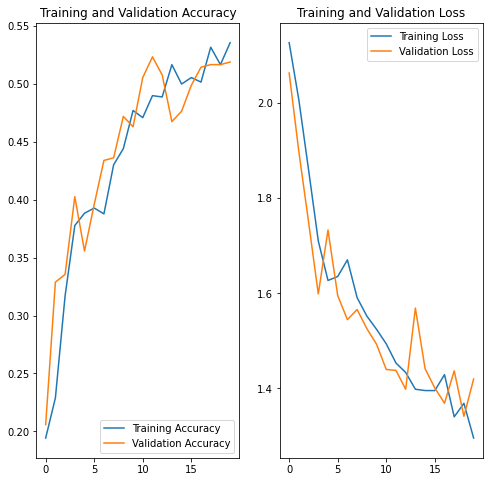

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Observations:**
1. Training and Validation accuracies have increased to ~54% and ~52% respectively. Hence, Data Augmentation has helped with model performance. 
2. There is no overfitting observed now as both the accuracies are inline with each other. Though they can be increased further and model performance can become better.   

# **Distribution of classes in the training dataset**

In [42]:
for i in train_ds.class_names:
    directory = 'gdrive/MyDrive/CNN_assignment/Train' + '/' + i + '/'
    class_directory = pathlib.Path(directory)
    length = len(list(class_directory.glob('*.jpg')))
    print(f'{i}: {length}')

actinic keratosis: 114
basal cell carcinoma: 376
dermatofibroma: 95
melanoma: 438
nevus: 357
pigmented benign keratosis: 462
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139


1. Significant imbalance is observed in above data. 
2. Least number of samples are in seborrheic keratosis (77).
3. Highest number of samples are in pigmented benign keratosis (462).

# **Model 3 - Rectifying class imbalance**

In [43]:
# install Augmentor package
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [44]:
path_to_training_dataset = 'gdrive/MyDrive/CNN_assignment/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation = 10, max_right_rotation = 10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD751186990>: 100%|██████████| 500/500 [00:20<00:00, 24.59 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD7511767D0>: 100%|██████████| 500/500 [00:18<00:00, 26.96 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD766045510>: 100%|██████████| 500/500 [00:18<00:00, 27.23 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FD7505DD810>: 100%|██████████| 500/500 [01:34<00:00,  5.29 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FD75065F990>: 100%|██████████| 500/500 [01:27<00:00,  5.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD7506F8390>: 100%|██████████| 500/500 [00:18<00:00, 26.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FD750673FD0>: 100%|██████████| 500/500 [00:44<00:00, 11.21 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD75065F1D0>: 100%|██████████| 500/500 [00:18<00:00, 26.70 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD7506FE450>: 100%|██████████| 500/500 [00:18<00:00, 27.19 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [46]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data

In [47]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/MyDrive/CNN_assignment/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031489.jpg_dde83499-5113-4c55-924f-2ea56d9040b8.jpg',
 'gdrive/MyDrive/CNN_assignment/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027858.jpg_4bc99867-37f4-4bd0-b72c-4ab57e02e424.jpg',
 'gdrive/MyDrive/CNN_assignment/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030197.jpg_430a9b5b-2841-42e2-9fee-3ed8151e4424.jpg',
 'gdrive/MyDrive/CNN_assignment/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026074.jpg_205696c0-cd73-4297-b621-b4282ad00bba.jpg',
 'gdrive/MyDrive/CNN_assignment/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026192.jpg_7f8433f1-0264-4a7a-92fe-7ab723e4dc30.jpg',
 'gdrive/MyDrive/CNN_assignment/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031597.jpg_5d2c28e2-3e5d-433c-8e79-b8f667b7b919.jpg',
 'gdrive/MyDrive/CNN_assignment/Train/basal cell carcinoma/outpu

In [48]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [50]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [52]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns = ['Path','Label'])

In [53]:
df2['Label'].value_counts()

basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
pigmented benign keratosis    500
actinic keratosis             500
seborrheic keratosis          500
vascular lesion               500
nevus                         500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# **Updating the train data set**

In [54]:
data_dir_train = path_to_training_dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed = 123,
  validation_split = 0.2,
  subset = 'training',
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


# **Updating the validation data set**

In [55]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed = 123,
  validation_split = 0.2,
  subset = 'validation',
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# **Creating the model**

In [56]:
model_class = Sequential()

model_class.add(tf.keras.layers.Rescaling(1./255, input_shape = input_shape))

model_class.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = input_shape, padding = 'same'))
model_class.add(BatchNormalization())
model_class.add(MaxPool2D(pool_size = (2, 2)))
model_class.add(Dropout(0.2))

model_class.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model_class.add(BatchNormalization())
model_class.add(MaxPool2D(pool_size = (2, 2)))
model_class.add(Dropout(0.2))

model_class.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model_class.add(BatchNormalization())
model_class.add(MaxPool2D(pool_size = (2, 2)))
model_class.add(Dropout(0.2))

model_class.add(Flatten())

model_class.add(Dense(512, activation = 'relu'))
model_class.add(Dropout(0.5))

model_class.add(Dense(9, activation = 'softmax'))

model_class.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)       

# **Compiling the model**

In [58]:
model_class.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

# **Training the model**

In [59]:
epochs = 50
history = model_class.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 34s 194ms/step - loss: 10.1616 - accuracy: 0.2235 - val_loss: 44.7630 - val_accuracy: 0.0631
Epoch 2/50
169/169 [==============================] - 33s 189ms/step - loss: 2.0237 - accuracy: 0.2174 - val_loss: 14.3432 - val_accuracy: 0.0987
Epoch 3/50
169/169 [==============================] - 32s 181ms/step - loss: 1.9043 - accuracy: 0.2654 - val_loss: 4.6317 - val_accuracy: 0.2376
Epoch 4/50
169/169 [==============================] - 31s 180ms/step - loss: 1.8354 - accuracy: 0.2752 - val_loss: 2.1784 - val_accuracy: 0.3185
Epoch 5/50
169/169 [==============================] - 33s 189ms/step - loss: 1.8041 - accuracy: 0.2843 - val_loss: 1.5942 - val_accuracy: 0.3601
Epoch 6/50
169/169 [==============================] - 32s 181ms/step - loss: 1.7637 - accuracy: 0.2956 - val_loss: 1.5905 - val_accuracy: 0.3281
Epoch 7/50
169/169 [==============================] - 32s 181ms/step - loss: 1.7387 - accuracy: 0.2960 - val_loss: 1.5062 - val_accuracy: 

# **Visualizing training results**

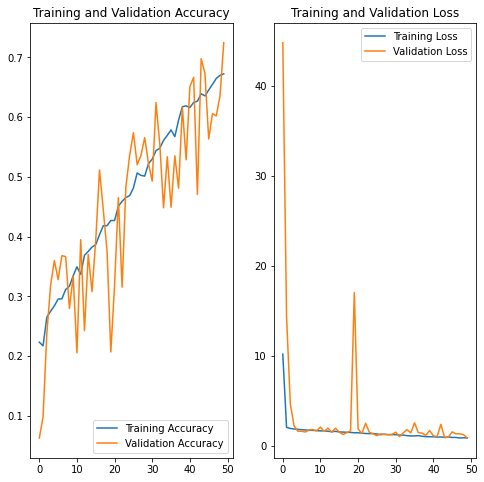

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Observations:**
1. Class rebalance helps with the model performance. 
2. There is no overfitting observed with the latest model. 
3. Infact validation accuracy is better than training accuracy. 
4. Performance of the model can be made better though.